In [2]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import torch.optim as optim

In [3]:
class AutoEncoder(torch.nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(2048, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU()
        )
        
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(256, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 2048)  # Sigmoid activation to restrict output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Example usage:
# Instantiate the autoencoder
autoencoder = AutoEncoder().cuda()
autoencoder.train()

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Download and extract the data

In [58]:
# import urllib.request
# urllib.request.urlretrieve("https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420937484-1629951672/carpet.tar.xz",
#                            "carpet.tar.xz")

# import tarfile

# with tarfile.open('carpet.tar.xz') as f:
#     f.extractall('.')

# Load a pretrained Resnet Model

In [7]:
from torchvision.models import resnet50, ResNet50_Weights
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
model = torch.nn.Sequential(*list(resnet_model.children())[:-1]).cuda()
model.eval()

for param in model.parameters():
    param.requires_grad = False

In [8]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.ToTensor()
])

train_image_path = Path('carpet/train')

good_dataset = ImageFolder(root=train_image_path, transform=transform)
train_dataset, test_dataset = torch.utils.data.random_split(good_dataset, [0.8, 0.2])

# Set the batch size
BS = 16

# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BS, shuffle=True)


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.0072, Validation Loss: 0.0064
Epoch [6/50], Loss: 0.0015, Validation Loss: 0.0015
Epoch [11/50], Loss: 0.0013, Validation Loss: 0.0015
Epoch [16/50], Loss: 0.0015, Validation Loss: 0.0014
Epoch [21/50], Loss: 0.0009, Validation Loss: 0.0010
Epoch [26/50], Loss: 0.0008, Validation Loss: 0.0011
Epoch [31/50], Loss: 0.0010, Validation Loss: 0.0010
Epoch [36/50], Loss: 0.0009, Validation Loss: 0.0010
Epoch [41/50], Loss: 0.0008, Validation Loss: 0.0008
Epoch [46/50], Loss: 0.0006, Validation Loss: 0.0006


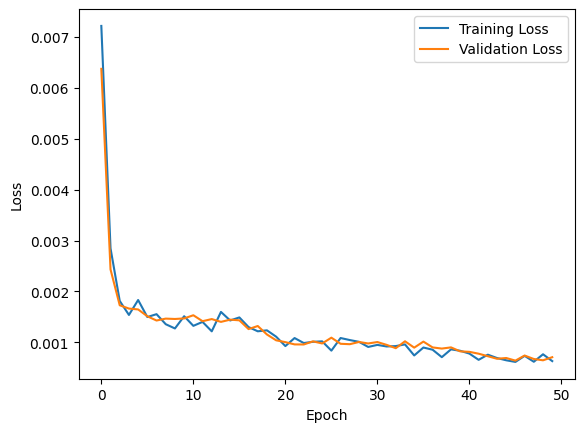

In [12]:
# Define a list to store training loss and validation loss
Loss = []
Validation_Loss = []


num_epochs = 50
for epoch in tqdm(range(num_epochs)):
    autoencoder.train()
    for data,_ in train_loader:
        with torch.no_grad():
            feature = model(data.cuda()).squeeze()
        # Forward pass
        output = autoencoder(feature)
        # Compute the loss
        loss = criterion(output, feature)
        # Backpropagation and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    Loss.append(loss.item())

    # Calculate validation loss
    autoencoder.eval()
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        val_loss_sum = 0.0
        num_batches = 0
        for data, _ in test_loader:
            feature = model(data.cuda()).squeeze()
            output = autoencoder(feature)
            val_loss = criterion(output, feature)
            val_loss_sum += val_loss.item()
            num_batches += 1
        val_loss_avg = val_loss_sum / num_batches
        Validation_Loss.append(val_loss_avg)
    
    if epoch % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch + 1, num_epochs, loss.item(), val_loss_avg))

plt.plot(Loss, label='Training Loss')
plt.plot(Validation_Loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [14]:
torch.save(autoencoder.state_dict(), 'autoencoder_with_resnet_features.pth')

# For OK images

In [15]:
autoencoder.eval()

RECON_ERROR=[]
for data,_ in train_loader:
    
    with torch.no_grad():
        feature = model(data.cuda()).squeeze()
        # Forward pass
        recon = autoencoder(feature)
    # Compute the loss
    recon_error =  ((feature-recon)**2).mean(axis=1)
    RECON_ERROR.append(recon_error)
    
RECON_ERROR = torch.cat(RECON_ERROR).cpu().numpy()

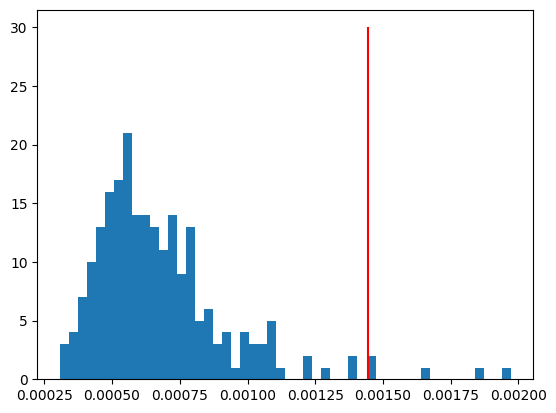

In [16]:
best_threshold = np.mean(RECON_ERROR) + 3 * np.std(RECON_ERROR)

plt.hist(RECON_ERROR,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

# For NOK Images

In [17]:
y_true=[]
y_pred=[]
y_score=[]

model.eval()
autoencoder.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)
    
    with torch.no_grad():
        feature = model(test_image).squeeze()
        # Forward pass
        recon = autoencoder(feature)
    
    y_score_image = ((feature -recon)**2).mean()
    y_pred_image = 1*(y_score_image >= best_threshold)
    
    y_true_image = 0 if fault_type == 'good' else 1
    
    y_true.append(y_true_image)
    y_pred.append(y_pred_image.cpu())
    y_score.append(y_score_image.cpu())
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_score = np.array(y_score)
    

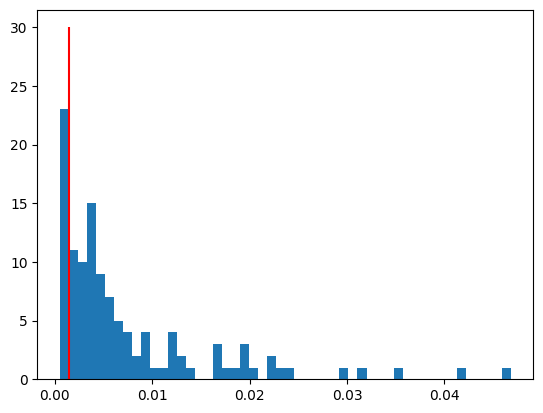

In [19]:
plt.hist(y_score,bins=50)
plt.vlines(x=best_threshold,ymin=0,ymax=30,color='r')
plt.show()

AUC-ROC Score: 0.7451845906902087


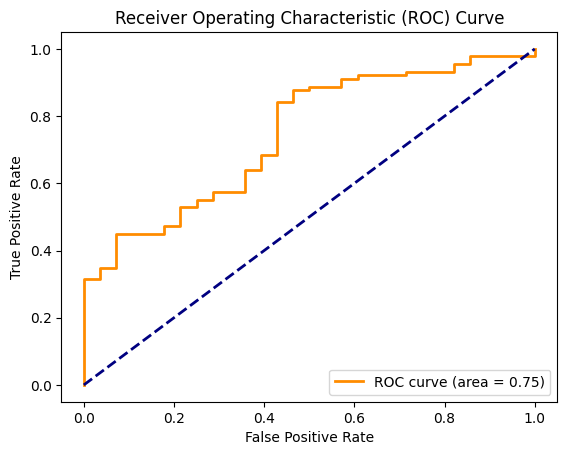

best_threshold = 0.0013709450140595436


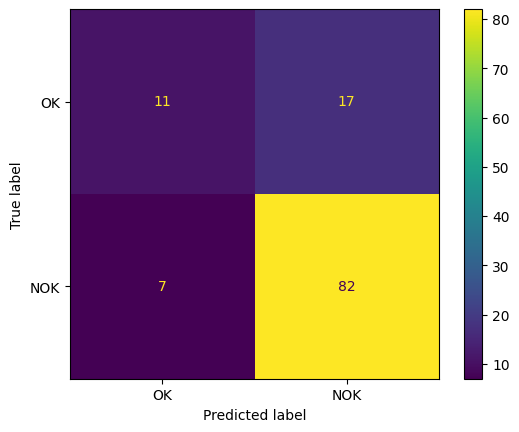

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns



# Calculate AUC-ROC score
auc_roc_score = roc_auc_score(y_true, y_score)
print("AUC-ROC Score:", auc_roc_score)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_roc_score)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



f1_scores = [f1_score(y_true, y_score >= threshold) for threshold in thresholds]

# Select the best threshold based on F1 score
best_threshold = thresholds[np.argmax(f1_scores)]

print(f'best_threshold = {best_threshold}')

# Generate confusion matrix
cm = confusion_matrix(y_true, (y_score >= best_threshold).astype(int))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['OK','NOK'])
disp.plot()
plt.show()


# Print miss classified samples

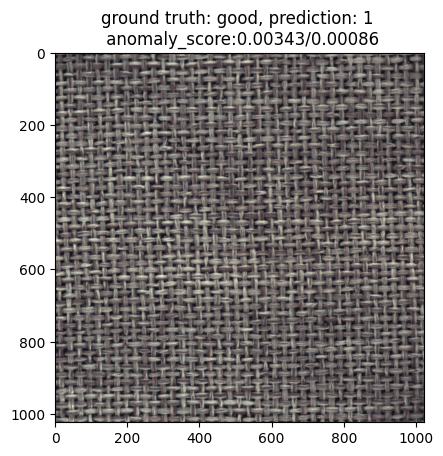

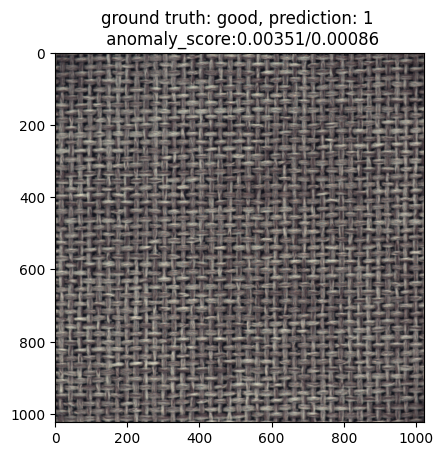

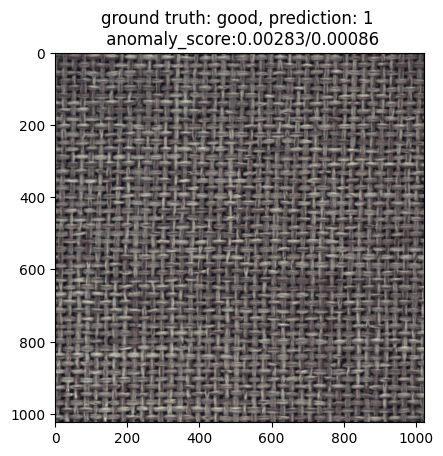

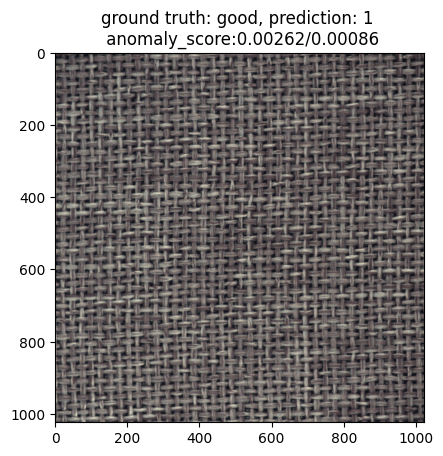

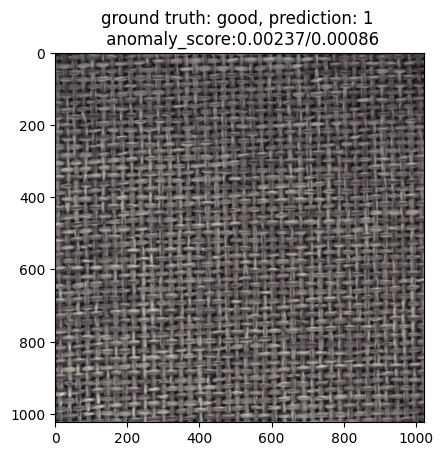

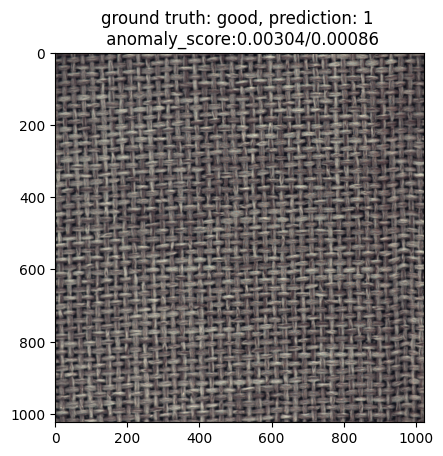

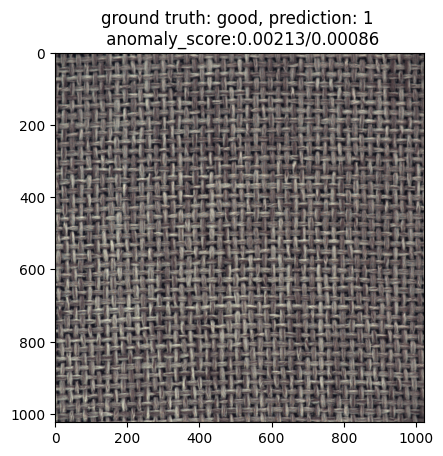

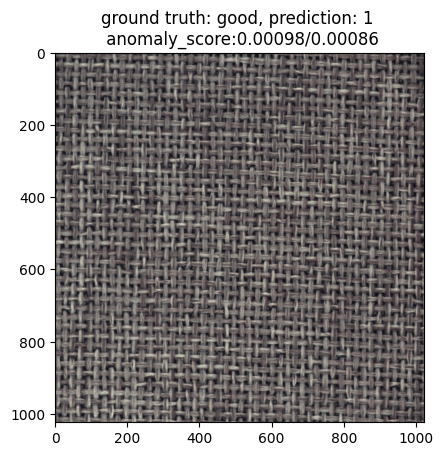

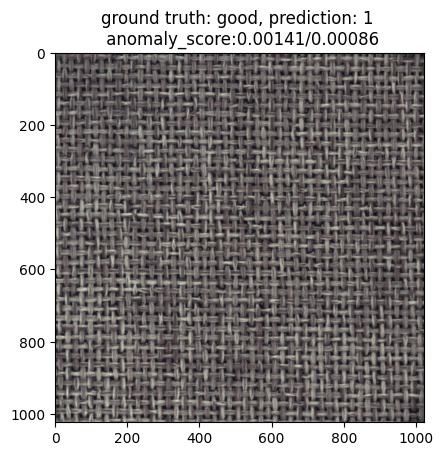

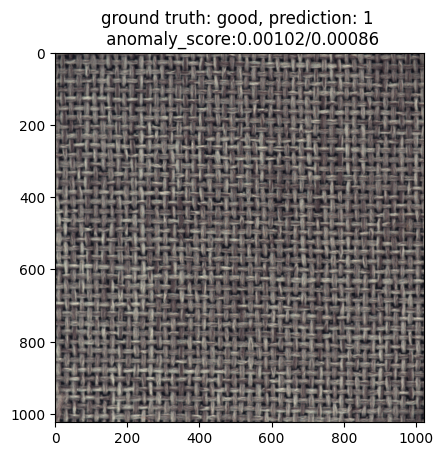

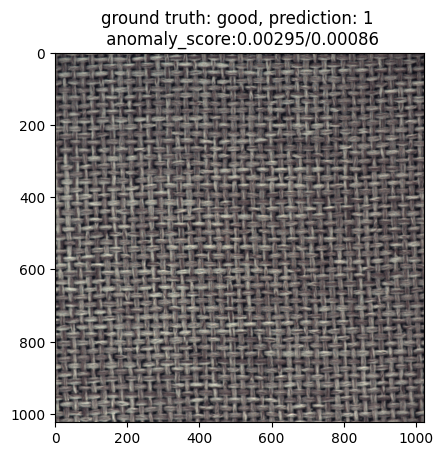

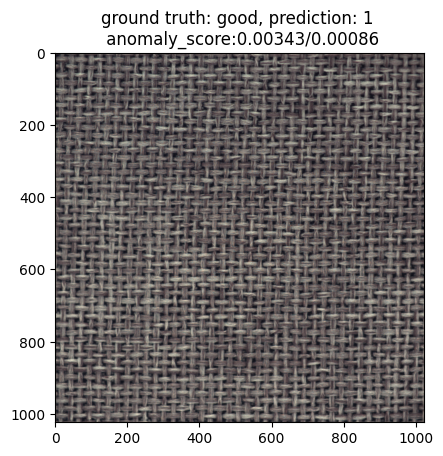

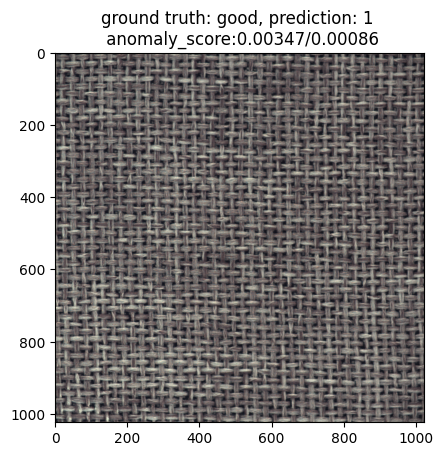

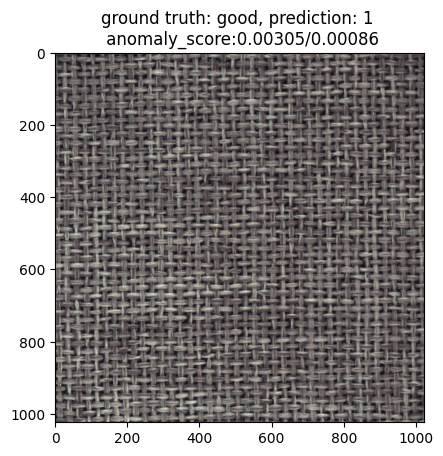

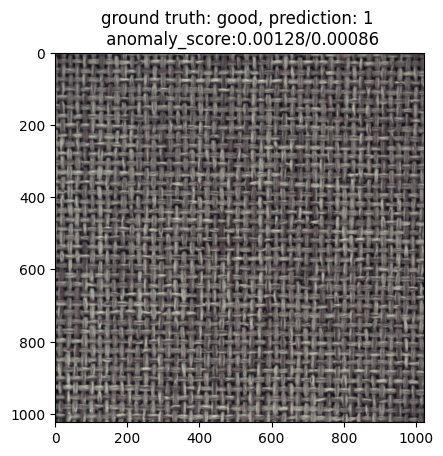

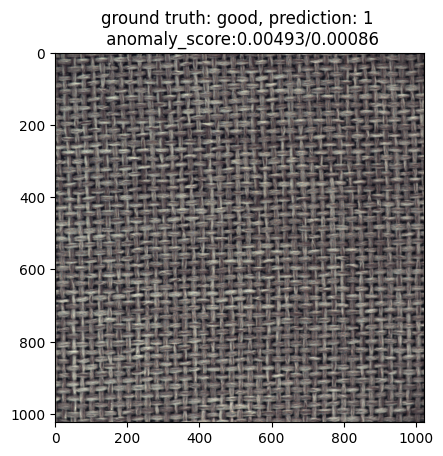

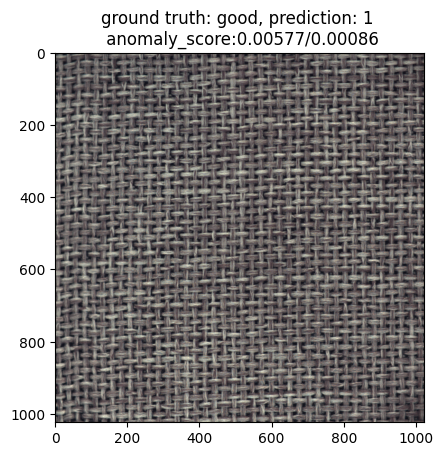

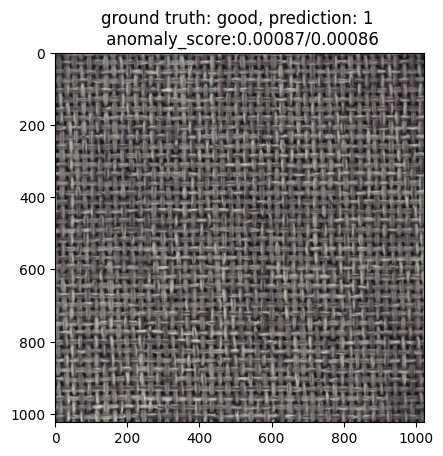

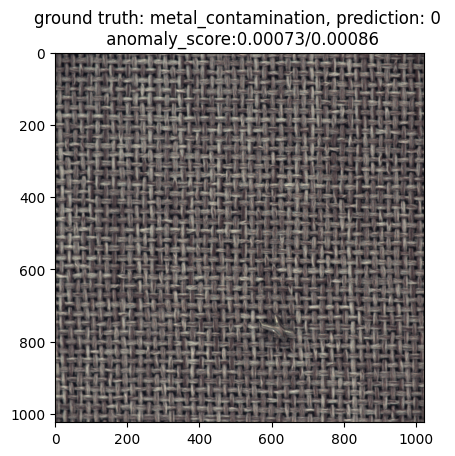

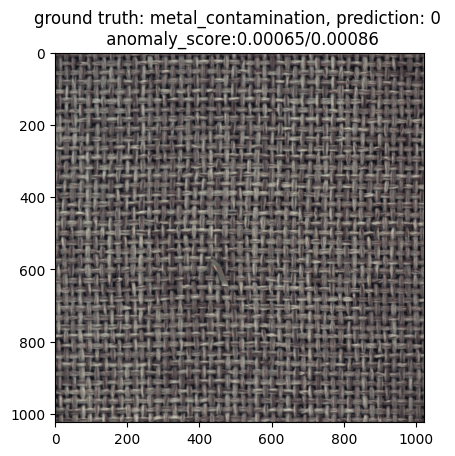

In [39]:
model.eval()
autoencoder.eval()

test_path = Path('carpet/test')

for path in test_path.glob('*/*.png'):
    fault_type = path.parts[-2]
    test_image = transform(Image.open(path)).cuda().unsqueeze(0)
    
    with torch.no_grad():
        feature = model(test_image).squeeze()
        # Forward pass
        recon = autoencoder(feature)
    
    y_score_image = ((feature -recon)**2).mean()
    y_pred_image = 1*(y_score_image >= best_threshold)
    
    y_true_image = 0 if fault_type == 'good' else 1
    
    if y_pred_image != y_true_image:
        plt.imshow(Image.open(path))
        plt.title(f'ground truth: {fault_type}, prediction: {y_pred_image} \n anomaly_score:{y_score_image:.5f}/{best_threshold:.5f}')
        plt.show()
    

    

    